In [2]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import configs
import seaborn as sns

# Parameters

In [3]:
internal_dim = 12
generic_exp_name = 'new_gridworld8x8_shuffobs'
network_yaml = 'dm'
episode = 600
models = ['mf0', 'g0_-2_entro-1', 'entro0']
model_labels = ['MF', 'MF + P/N', 'MF + N']

In [4]:
engram_dir = '/Volumes/aronov-locker/Ching/rl/'
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/' # Axon path

In [5]:
dims = np.arange(2,20)

In [6]:
episode = 600

# Collecting info

In [7]:
data = {
    'dims': [],
    'zerofields': [],
    'models': []
}

for internal_dim in dims:
    exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
    analysis_dir = f'{engram_dir}analysis/{exp_name}/'
    repr_df_path = f'{analysis_dir}representation_df_ep{episode}.p'
    if not os.path.exists(repr_df_path):
        continue
    with open(repr_df_path, 'rb') as f:
        repr_df = pickle.load(f)
    for model in models:
        _model = f'{generic_exp_name}_{model}'
        model_df = repr_df[repr_df['model'] == _model]
        if model_df.empty:
            continue
        iterations = np.unique(model_df['iteration'])
        for i in iterations:
            _df = model_df[model_df['iteration'] == i]
            width = np.max(_df['x']) + 2
            height = np.max(_df['y']) + 2
            _sample = np.array(_df.head(1)['latents'].item())
            n_units = _sample.size
            heatmap = np.zeros((n_units, width, height))
            for _, row in _df.iterrows():
                x = row['x']
                y = row['y']
                latents = np.array(row['latents'])
                heatmap[:,x,y] = latents
            heatmap[heatmap<0] = 0
            hh = np.sum(heatmap.reshape((internal_dim,-1)), axis=1)
            data['dims'].append(internal_dim)
            data['zerofields'].append(np.sum(hh < 1E-4)/internal_dim)
            data['models'].append(model)

# Measuring collapse

In [8]:
import pandas as pd

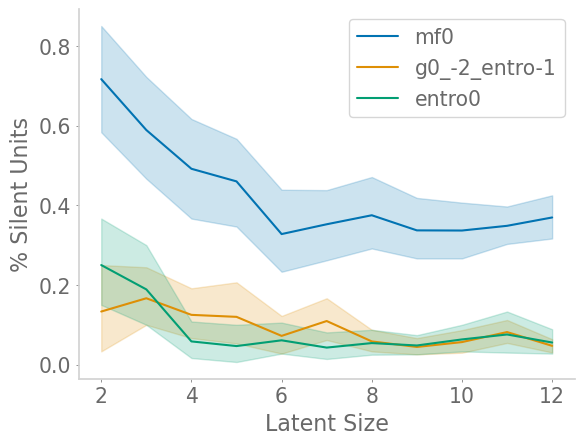

In [9]:
fig, ax = plt.subplots()
sns.lineplot(
    x='dims', y='zerofields', data=pd.DataFrame(data),
    hue='models', hue_order=models, ax=ax,
    )
ax.set_ylabel('% Silent Units')
ax.set_xlabel('Latent Size')
plt.legend()

# # Replace legend names
# label_list = []
# for t in ax.get_legend_handles_labels():
#     label_list.append(t)
# label_list[1] = model_labels
# ax.legend(handles=label_list[0], labels=label_list[1])


In [17]:
df = pd.DataFrame(data)

In [18]:
from scipy.stats import sem

In [19]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


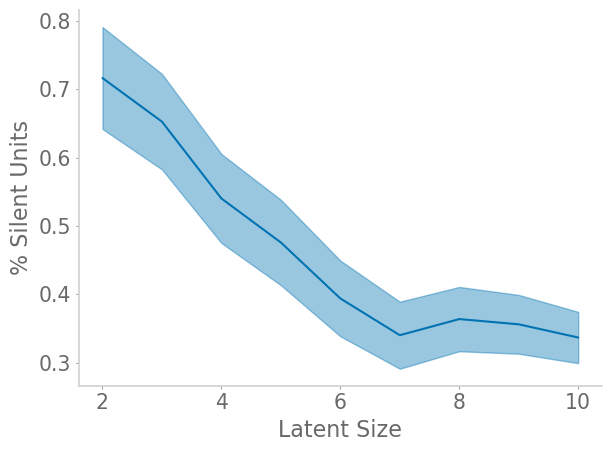

In [20]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', colors(c_steps[0])]
smooth_line = True
fig, ax = plt.subplots()
for _idx, model in enumerate([
     'mf0', 'g0_-2_entro-2'
    ]):
    means = []
    sems = []
    for d in np.arange(2,11):
        r = df[(df['models']==model) & (df['dims']==d)]
        zerofields = r['zerofields']
        means.append(np.mean(zerofields))
        sems.append(sem(zerofields))
    means = np.array(means)
    sems = np.array(sems)
    if smooth_line:
        means[1:-1] = smooth(np.arange(2,11), means, 2)[1:-1]
        sems[1:-1] = smooth(np.arange(2,11), np.array(sems), 2)[1:-1]
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    ax.plot(np.arange(2,11), means, label=model, color=colors[_idx])
    ax.fill_between(
        np.arange(2,11), mean_lowerbound,
        mean_upperbound, alpha=0.4, color=colors[_idx])
plt.ylabel('% Silent Units')
plt.xlabel('Latent Size')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()